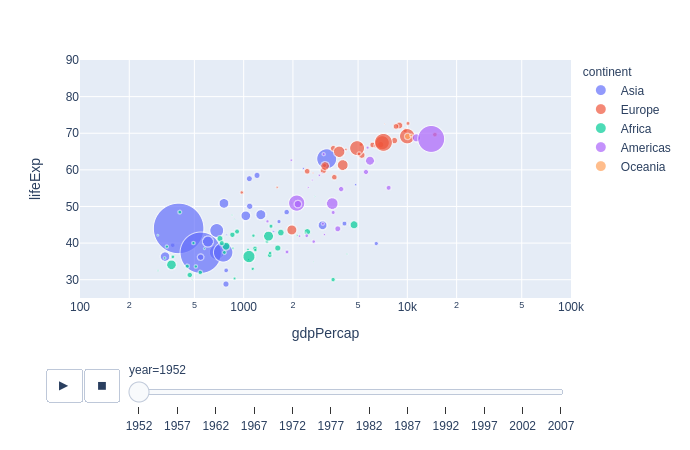

In [10]:
import plotly.express as px
df = px.data.gapminder()
px.scatter(df, x="gdpPercap", y="lifeExp", animation_frame="year", animation_group="country",
           size="pop", color="continent", hover_name="country",
           log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90])

In [11]:
import pandas as pd 
import numpy as np

In [57]:
def segmentacion(ts, distance_between_windows, threshold=None, 
                 limit_percentile=5, segment_spacing=0, growing_rate=1, 
                 distance_function=None, min_history_length=None):

   
    distance_between_windows = int(distance_between_windows)
    min_history_length = int(min_history_length)
    segment_spacing = int(segment_spacing)


    if min_history_length is None:
        min_history_length = distance_between_windows
        
    def default_threshold(j):
        lower = j[-1] < np.percentile(j[:-1], limit_percentile)
        upper = j[-1] > np.percentile(j[:-1], 100 - limit_percentile)
        return lower or upper
    
    if threshold is None:
        threshold = default_threshold 

    base = 0
    secondary_end = base + 1
    primary_end = secondary_end + distance_between_windows
    history = []
    change_indexes = []
    upper = [np.nan] * primary_end
    lower = [np.nan] * primary_end
    distances = [np.nan] * primary_end
    ids = []
    
    while primary_end < len(ts):
        primary = ts[base : primary_end]
        secondary = ts[base : secondary_end]
        distance = distance_function(primary, secondary)
        history.append(distance)
    
        distances.append(distance)
        ids.append(base+primary_end)

        if len(history) >= min_history_length:
            lower.append(np.percentile(history[:-1], limit_percentile))
            upper.append(np.percentile(history[:-1], 100 - limit_percentile))
            if threshold(history):  
                change_indexes.append(primary_end)
                base = primary_end + segment_spacing
                history = []
                secondary_end = base + 1
                primary_end = secondary_end + distance_between_windows
                continue
        else:
            lower.append(np.nan)
            upper.append(np.nan)

        secondary_end += growing_rate
        primary_end += growing_rate

    change_indexes = np.array(change_indexes, dtype = int)
    change_values = ts[change_indexes]

    return change_indexes, change_values, upper, lower, distances, ids



def select_distance(name=None, power=2):
    if name == "mean_sqr":
        return lambda x, y: (1 + x.mean() - y.mean()) ** power
    
    if name == "mean":
        return lambda x, y: abs(x.mean() - y.mean())
    
    if name == "maxi":
        return lambda x, y: abs(x.max() - y.max())
    
    if name == "maxi_sqr":
        return lambda x, y: (x.max() - y.max()) ** power
    
    if name == "mini":
        return lambda x, y: abs(x.max() - y.max())
    
    if name == "mini_sqr":
        return lambda x, y: (x.max() - y.max()) ** power
    
    if name == "std":
        return lambda x, y: abs(x.std(ddof=1) - y.std(ddof=1))
    
    if name == "std_sqr":
        return lambda x, y: (x.std(ddof=1) - y.std(ddof=1)) ** power
    
    print(name)
    raise Exception(f"Available Options are: mean_sqr, mean, maxi, maxi_sqr, mini, mini_sqr, std, std_sqr")
    
def select_threshold(name, limit_percentile=5):
    if name == "percentile":
        return lambda j: j[-1] < np.percentile(j[:-1], limit_percentile) or j[-1] > np.percentile(j[:-1], 100 - limit_percentile)
    
    if name == "std":
        return lambda j: j[-1] > 3 * np.std(j[:-1]) + np.mean(j[:-1]) or j[-1] < 3 * np.std(j[:-1]) - np.mean(j[:-1])
    
    if name == "edge":
        return lambda j: j[-1] > np.max(j[:-1]) or j[-1] < np.min(j[:-1])

In [48]:
params = {'distance_between_windows': 326.0, 'limit_percentile': 3.886, 'min_history_length': 695.0, 'segment_spacing': 0}
params['distance_function'] = select_distance('mean_sqr')
params

{'distance_between_windows': 326.0,
 'limit_percentile': 3.886,
 'min_history_length': 695.0,
 'segment_spacing': 0,
 'distance_function': <function __main__.select_distance.<locals>.<lambda>(x, y)>}

In [58]:
y = pd.read_csv('Concentration1-1.csv').values.flatten()
indices, valores, upper, lower, distances, ids = segmentacion(y, **params)

In [62]:
len(upper)

9106

In [69]:
lower[1021]

0.9949997449989163

In [68]:
distances[1021]

0.9948434902239122

In [67]:
upper[1021]

1.0032410494162654

In [61]:
ids[-1]

16203